In [4]:
%matplotlib inline
import numpy as np
from numpy import pi
from qiskit import *
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex

def list_backends():
    provider = IBMQ.get_provider("ibm-q")
    for backend in provider.backends():
        try:
            qubit_count = len(backend.properties().qubits)
        except:
            qubit_count = "simulated"
        
        print(backend.name(), "has", backend.status().pending_jobs, "qued and", qubit_count, "qubits")

def run(b, circuit):
    provider = IBMQ.get_provider("ibm-q")
    backend = provider.get_backend(b)
    job = q.execute(circuit, backend=backend, shots=1000)
    job_monitor(job)
    return(job)
IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-07-07 13:12:44,329: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

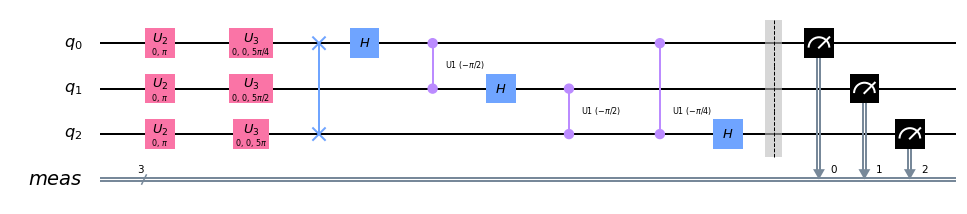

In [5]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cu1(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() 

# Let's see how it looks:
nqubits = 3
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.u1(number*pi/4,0)
qc.u1(number*pi/2,1)
qc.u1(number*pi,2)

qc = inverse_qft(qc,nqubits)
qc.measure_all()

qc.draw('mpl')

Job Status: job has successfully run


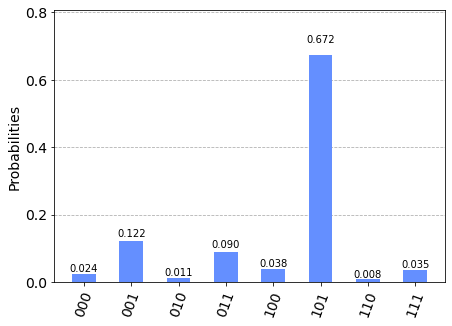

In [6]:
job = run("ibmqx2", qc)

result = job.result()
counts = result.get_counts(qc)
plot_histogram([counts])